In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami
from vittles import solver_lib

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# np.random.seed(53453)

# load data

In [3]:
data_file = '../../../../fastStructure/test/testdata.npz'
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# Load initial fit

In [5]:
alpha0 = 9.

In [6]:
fit_files = '../fits/fits_20201106/testdata_fit_alpha'

In [7]:
vb_params_dict, vb_params_paragami, meta_data = \
    paragami.load_folded(fit_files + '{}.npz'.format(alpha0))

print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (500, 20, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (200, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (200, 19) (lb=0.0001, ub=inf)


In [8]:
vb_opt_dict = deepcopy(vb_params_dict)
vb_opt = vb_params_paragami.flatten(vb_params_dict, free = True)

In [9]:
k_approx = vb_params_dict['pop_freq_beta_params'].shape[1]
print(k_approx)

20


In [10]:
gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)

use_logitnormal_sticks = meta_data['use_logitnormal_sticks'] == 1

# Get prior

In [35]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

prior_params_dict['dp_prior_alpha'] = np.array(meta_data['dp_prior_alpha'])
prior_params_dict['allele_prior_alpha'] = np.array(meta_data['allele_prior_alpha'])
prior_params_dict['allele_prior_beta'] = np.array(meta_data['allele_prior_beta'])

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([9.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


In [36]:
kl = structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                                gh_loc = gh_loc, gh_weights = gh_weights)

In [37]:
kl

DeviceArray(113691.74956933, dtype=float64)

In [38]:
# check KL's match
print(np.abs(kl - meta_data['final_kl']))
assert np.abs(kl - meta_data['final_kl']) < 1e-8

7.275957614183426e-11


# Plot inferred cluster belongings

In [39]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0]

# get large clusters
top_clusters = np.argsort(- e_ind_admix.sum(0))

# we color the top clusters
# all else is grey
n_clusters_plot = 3
import colorsys
colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,n_clusters_plot+1)[:-1]]

colors_plus_grey = ['grey'] * k_approx

for i in range(n_clusters_plot): 
    colors_plus_grey[top_clusters[i]] = colors[i]

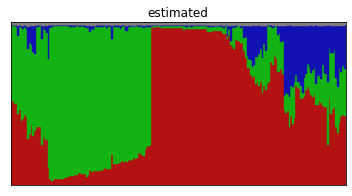

In [40]:
# re-order individuals for better plotting
indx = data_utils.cluster_admix_get_indx(e_ind_admix)

f, axarr = plt.subplots(1, 1, figsize=(6, 3))
plotting_utils.plot_admixture(e_ind_admix[indx], axarr, colors = colors_plus_grey)
axarr.set_title('estimated');

# Define sensitivity object

In [41]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'], 
                                                              free = use_free_alpha)

In [42]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


### Get hessian solver

In [43]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_sqrt = False, 
                                            return_info = True)
t0 = time.time()
_ = cg_precond(vb_opt)
print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 1.27sec


### Compute VB sensitivity derivatives

In [44]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        prior_alpha0, 
                                                        cg_precond=cg_precond)

Compiling hessian solver ...
Hessian solver compile time: 142.828sec

Compiling cross hessian...
Cross-hessian compile time: 56.6493sec

LR sensitivity time: 32.3339sec



# Load results from a range of alpha

In [45]:
alpha_list = np.arange(1, 11.5, step = 0.5)

In [46]:
print('alphas: ', alpha_list)

alphas:  [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11. ]


In [47]:
vb_pert_list = []
for alpha in alpha_list: 
    
    fit_file = fit_files + '{:.1f}.npz'.format(alpha)
    
    print('loading results from: ', fit_file)
    
    vb_params_dict, _, meta_data = paragami.load_folded(fit_file)
    
    # check KL's match 
    assert np.abs(objective_fun(vb_params_dict, 
                                meta_data['dp_prior_alpha']) - \
                  meta_data['final_kl']) < 1e-8
    
    vb_pert_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))

loading results from:  ../fits/fits_20201106/testdata_fit_alpha1.0.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha1.5.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha2.0.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha2.5.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha3.0.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha3.5.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha4.0.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha4.5.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha5.0.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha5.5.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha6.0.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha6.5.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha7.0.npz
loading results from:  ../fits/fits_20201106/testdata_fit_alpha7.5.npz
loadin

# Check free parameters

In [48]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha)))


In [49]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


<ipython-input-50-6daf489f72d3>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


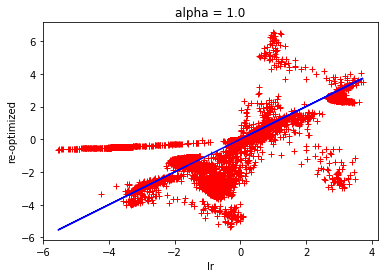

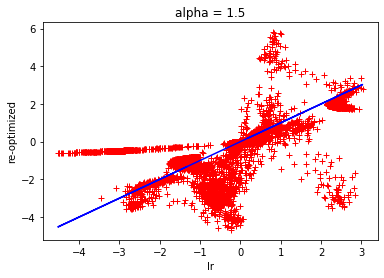

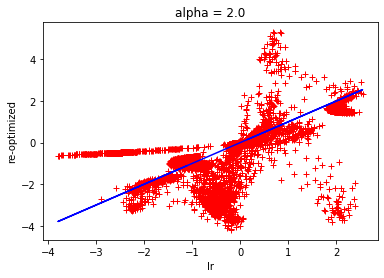

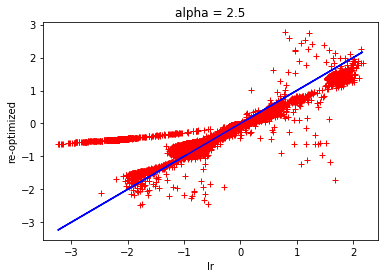

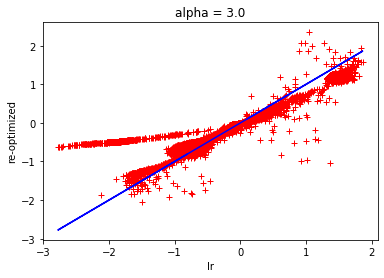

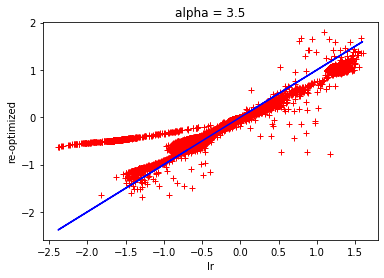

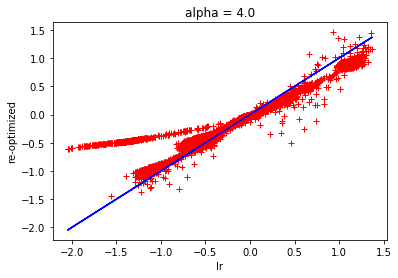

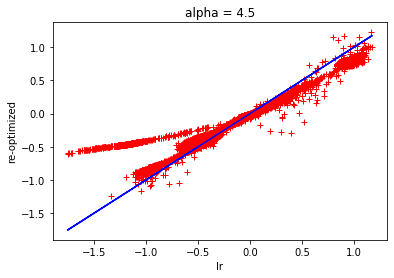

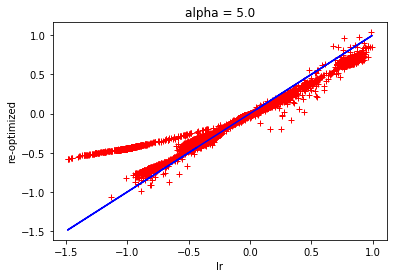

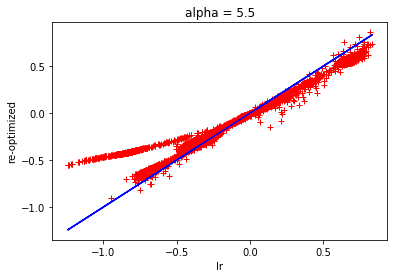

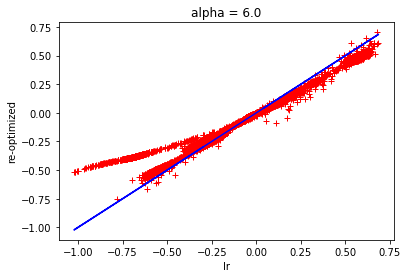

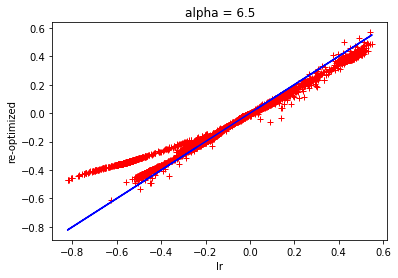

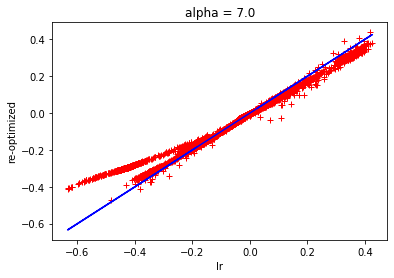

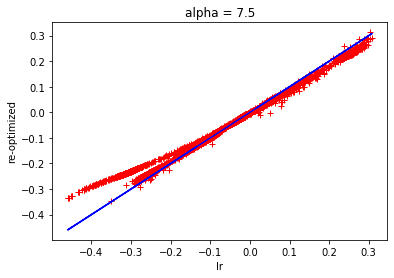

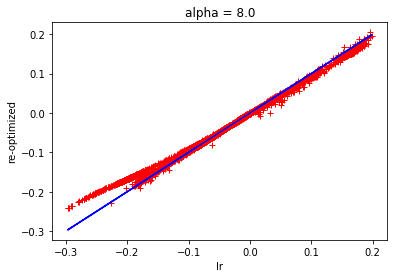

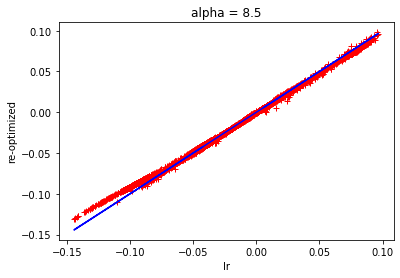

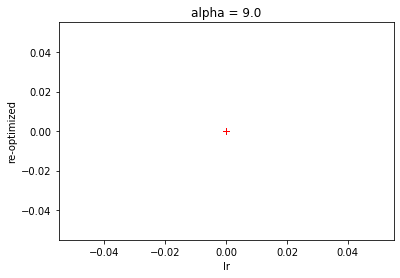

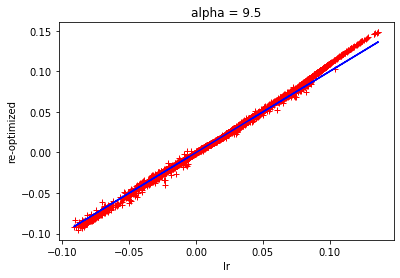

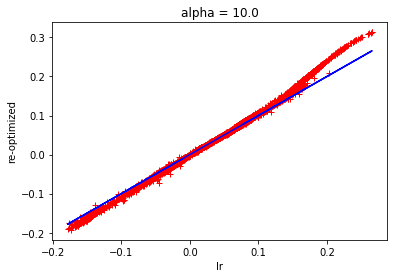

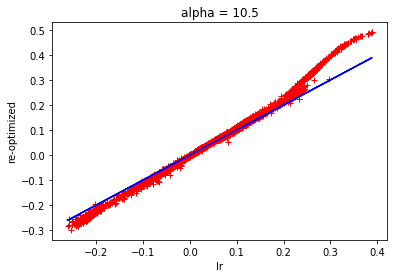

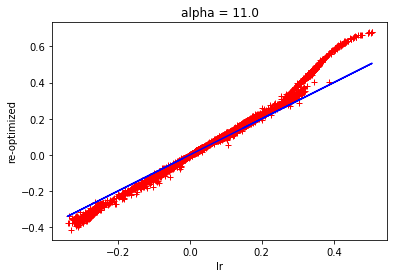

In [50]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


In [51]:
# for i in range(len(alpha_list)): 
    
#     # get dictionaries
#     pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
#     lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
#     # estimated admixtures
#     pert_e_ind_admix = plotting_utils.get_vb_expectations(pert_dict, gh_loc, gh_weights)[0]
#     lr_e_ind_admix = plotting_utils.get_vb_expectations(lr_dict, gh_loc, gh_weights)[0]

#     # plot
#     f, axarr = plt.subplots(1, 2, figsize=(12, 3))

#     # plot refit 
#     plotting_utils.plot_admixture(pert_e_ind_admix[indx], axarr[1])
#     axarr[1].set_title('refit; alpha = {}'.format(alpha_list[i]))
    
#     # plot estimated
#     plotting_utils.plot_admixture(lr_e_ind_admix[indx], axarr[0])
#     axarr[0].set_title('lr;  alpha = {}'.format(alpha_list[i]))


# Number of clusters

In [52]:
import numpy as onp

In [53]:
lr_e_num_clusters_vec = onp.zeros(len(alpha_list))
refit_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix = plotting_utils.get_vb_expectations(pert_dict, gh_loc, gh_weights)[0]
    lr_e_ind_admix = plotting_utils.get_vb_expectations(lr_dict, gh_loc, gh_weights)[0]
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


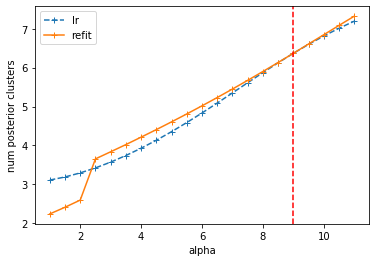

In [54]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['dp_prior_alpha'], color = 'red', linestyle = 'dashed')

In [31]:
# for loading in an already saved hessian inverse solution ... 

# class VBSensitivity(object): 
#     def __init__(self, lr_file, opt_par_value, hyper_par_value0): 
#         self.dinput_dhyper = np.load(lr_file)
        
#         self.opt_par_value = opt_par_value
#         self.hyper_par_value0 = hyper_par_value0
        
#     def predict_opt_par_from_hyper_par(self, hyper_par_value):
#         delta = (hyper_par_value - self.hyper_par_value0)

#         if len(self.dinput_dhyper.shape) == 1:
#             self.dinput_dhyper = np.expand_dims(self.dinput_dhyper, 1)

#         return np.dot(self.dinput_dhyper, delta) + self.opt_par_value

In [32]:
# load_lr_der = True
# if load_lr_der: 
#     lr_file = fit_dir + 'alpha_sens_nobs{}_nloci{}_npop{}_alpha{}.npy'.format(n_obs, 
#                                                                           n_loci, 
#                                                                           n_pop, 
#                                                                           alpha0)
#     vb_sens = VBSensitivity(lr_file, vb_opt, prior_alpha0)
# else: 
#     vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
#                                                         vb_opt,
#                                                         prior_alpha0, 
#                                                         cg_precond=cg_precond)

In [33]:
# def e_num_clusters_from_ez(vb_params_dict, gh_loc, gh_weights): 
#     e_log_sticks, e_log_1m_sticks, \
#         e_log_pop_freq, e_log_1m_pop_freq = \
#             structure_model_lib.get_moments_from_vb_params_dict(vb_params_dict,
#                                     gh_loc = gh_loc,
#                                     gh_weights = gh_weights)
#     e_log_cluster_probs = \
#         modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
#                             e_log_sticks, e_log_1m_sticks)
    
    
#     prod_ez = 1.
#     for l in range(g_obs.shape[1]):
#         _, e_z_l = structure_model_lib.get_optimal_ezl(g_obs[:, l],
#                                 e_log_pop_freq[l], e_log_1m_pop_freq[l],
#                                 e_log_cluster_probs)
        
#         prod_ez *= (1 - e_z_l).prod(2).prod(0)
                
#     return prod_ez